Mooncoin Market Analysis
========================

Documentation:
- https://github.com/ccxt/ccxt/wiki

In [1]:
import ccxt
from pydash import py_ as _
from datetime import datetime, timedelta
from dateutil.parser import parse
import pandas as pd
import datetime
import numpy as np
import matplotlib
import re

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 8)
pd.set_option('display.max_rows', 8)

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [2]:
bleutrade = ccxt.bleutrade()
bittrex   = ccxt.bittrex()

In [3]:
moonbtc_trades = pd.DataFrame(bleutrade.fetch_trades("MOON/BTC", params={"count": 200}), columns=['amount', 'datetime', 'side', 'info'])
moonbtc_trades['price']      = moonbtc_trades['info'].map(lambda x: float(x['Price']))
moonbtc_trades['btc_amount'] = moonbtc_trades['amount'] * moonbtc_trades['price']
del moonbtc_trades['info']
moonbtc_trades['datetime'] = pd.to_datetime(moonbtc_trades['datetime']) # convert seconds to nanoseconds
moonbtc_trades

           amount            datetime side         price  btc_amount
0    4.890245e+06 2018-01-01 11:12:27  buy  2.000000e-08    0.097805
1    1.746458e+07 2018-01-01 11:11:31  buy  2.000000e-08    0.349292
2    2.094763e+07 2018-01-01 11:11:31  buy  2.000000e-08    0.418953
3    3.000000e+05 2018-01-01 11:11:31  buy  2.000000e-08    0.006000
..            ...                 ...  ...           ...         ...
196  6.000000e+05 2018-01-01 09:05:55  buy  2.000000e-08    0.012000
197  2.222368e+06 2018-01-01 09:05:55  buy  2.000000e-08    0.044447
198  3.529676e+03 2018-01-01 09:05:06  buy  2.000000e-08    0.000071
199  1.000000e+05 2018-01-01 08:53:52  buy  2.000000e-08    0.002000

[200 rows x 5 columns]

Mooncoin Volumes
----------------

**How far back in time does bleutrade order moonbtc_trades go?**

- 2017-12-31: for max moonbtc_trades of 200 orders, Timedelta('0 days 11:28:11'), which is less than a day

In [4]:
moonbtc_trades['datetime'].max() - moonbtc_trades['datetime'].min()

Timedelta('0 days 02:18:35')

**What is the average order size?**

- 2017-12-31: Average orders are BTC 0.006385 (buy@2) - 0.007357 (sell@1) which is about $85-100 USD
- 2017-12-31: Average orders are BTC 0.034786 (buy@2) - 0.000630 (sell@1) which is an order of magnitude shift in both directions

In [5]:
moonbtc_trades.groupby('side').mean()

            amount         price  btc_amount
side                                        
buy   1.739293e+06  2.000000e-08    0.034786
sell  6.300039e+04  1.000000e-08    0.000630

**What is the relative volume on the buy and sell sides of the market**

- 2017-12-31: There is currently 2.9x BTC / 5.8x MOON volume on the sell@1 side of the market
- 2018-01-01: There is currently 3.4 BTC / 6.8x MOON volume on the buy@2 side of the market

In [6]:
moonbtc_trades_sum = moonbtc_trades[['amount', 'btc_amount','side']].groupby('side').sum()
moonbtc_trades_sum

            amount  btc_amount
side                          
buy   3.443801e+08    6.887602
sell  1.260008e+05    0.001260

In [7]:
moonbtc_trades_sum.loc['sell'] / moonbtc_trades_sum.loc['buy']

amount        0.000366
btc_amount    0.000183
dtype: float64

**Can we plot a chart for the buy/sell volume history**

- 2017-12-31 - Apart from a massive 0.9 BTC sell@1 spike at 7am, volumes remain low but about even on both sides of the market
- 2018-01-01 - Massive 5 BTC buy@2 spike at 10am

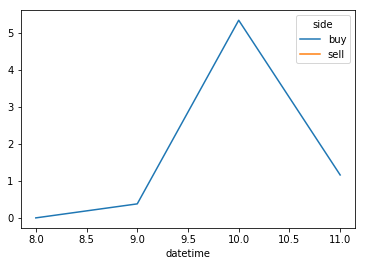

In [14]:
moonbtc_trades_agg = moonbtc_trades.groupby([moonbtc_trades['datetime'].dt.hour, 'side'])['btc_amount'].sum()
moonbtc_trades_agg.unstack().plot()

Price
-----

** What is the price of mooncoin **

In [9]:
tickers = {
    'bleutrade': bleutrade.fetch_tickers(),
    'bittrex':   bittrex.fetch_tickers()
}
tickers['bleutrade']['MOON/BTC']

{'ask': 2e-08,
 'average': None,
 'baseVolume': 683103739.8300378,
 'bid': 1e-08,
 'change': None,
 'close': None,
 'datetime': '2018-01-01T11:13:04.000Z',
 'first': None,
 'high': 2e-08,
 'info': {'Ask': '0.00000002',
  'Average': '0.00000002',
  'BaseCurrency': 'Bitcoin',
  'BaseVolume': '13.03672103',
  'Bid': '0.00000001',
  'High': '0.00000002',
  'IsActive': 'true',
  'Last': '0.00000002',
  'Low': '0.00000001',
  'MarketCurrency': 'Mooncoin',
  'MarketName': 'MOON_BTC',
  'PrevDay': '0.00000002',
  'TimeStamp': '2018-01-01 11:13:04',
  'Volume': '683103739.83003783'},
 'last': 2e-08,
 'low': 1e-08,
 'open': None,
 'percentage': None,
 'quoteVolume': 13.03672103,
 'symbol': 'MOON/BTC',
 'timestamp': 1514805184000,
 'vwap': None}

In [10]:
def bid(market):       return market['bid']
def mid(market):       return (market['ask'] + market['bid'])/2
def spread(market):    return (market['ask'] - market['bid'])
def spread_pc(market): return spread(market)/mid(market)

In [11]:

price = {'bittrex': {}, 'bleutrade': {}}
price['bittrex']['BTC/USDT']    = bid(tickers['bittrex']['BTC/USDT'])
price['bittrex']['DOGE/BTC']    = bid(tickers['bittrex']['DOGE/BTC'])
price['bittrex']['ETH/BTC']     = bid(tickers['bittrex']['ETH/BTC'])
price['bleutrade']['DOGE/BTC']  = bid(tickers['bleutrade']['DOGE/BTC'])
price['bleutrade']['ETH/BTC']   = bid(tickers['bleutrade']['ETH/BTC'])
price['bleutrade']['MOON/BTC']  = bid(tickers['bleutrade']['MOON/BTC'])
price['bleutrade']['MOON/DOGE'] = bid(tickers['bleutrade']['MOON/DOGE'])
price['bleutrade']['MOON/ETH']  = bid(tickers['bleutrade']['MOON/ETH']) 

price['bleutrade']['MOON/ETH/BTC']     = price['bleutrade']['MOON/ETH']  * price['bleutrade']['ETH/BTC']
price['bleutrade']['MOON/DOGE/BTC']    = price['bleutrade']['MOON/DOGE'] * price['bleutrade']['DOGE/BTC']
price['bittrex']['MOON/ETH/BTC']       = price['bleutrade']['MOON/ETH']  * price['bittrex']['ETH/BTC']
price['bittrex']['MOON/DOGE/BTC']      = price['bleutrade']['MOON/DOGE'] * price['bittrex']['DOGE/BTC']
price['bittrex']['MOON/ETH/BTC/USDT']  = price['bleutrade']['MOON/ETH/BTC']  * price['bittrex']['BTC/USDT']
price['bittrex']['MOON/DOGE/BTC/USDT'] = price['bleutrade']['MOON/DOGE/BTC'] * price['bittrex']['BTC/USDT']
price['bittrex']['MOON/BTC/USDT']      = price['bleutrade']['MOON/BTC']      * price['bittrex']['BTC/USDT']                                                                                         

price                                                                                              

{'bittrex': {'BTC/USDT': 13140.3139,
  'DOGE/BTC': 6.3e-07,
  'ETH/BTC': 0.05601881,
  'MOON/BTC/USDT': 0.000131403139,
  'MOON/DOGE/BTC': 1.83330063e-08,
  'MOON/DOGE/BTC/USDT': 0.00023325379219481476,
  'MOON/ETH/BTC': 1.6805643e-08,
  'MOON/ETH/BTC/USDT': 0.00021760363760494166},
 'bleutrade': {'DOGE/BTC': 6.1e-07,
  'ETH/BTC': 0.05520001,
  'MOON/BTC': 1e-08,
  'MOON/DOGE': 0.02910001,
  'MOON/DOGE/BTC': 1.7751006099999998e-08,
  'MOON/ETH': 3e-07,
  'MOON/ETH/BTC': 1.6560003e-08}}

In [12]:
bleutrade_markets = pd.DataFrame(bleutrade.fetch_tickers()).transpose()[['ask', 'bid', 'last']]
bleutrade_markets['mid']    = (bleutrade_markets['ask'] + bleutrade_markets['bid']) / 2
bleutrade_markets['spread'] = (bleutrade_markets['ask'] - bleutrade_markets['bid']) / bleutrade_markets['bid']
bleutrade_markets = bleutrade_markets.filter(regex="MOON/|ETH/|DOGE/", axis=0)
bleutrade_markets

                 ask        bid       last        mid     spread
DOGE/BTC     6.3e-07    6.1e-07    6.2e-07    6.2e-07  0.0327869
DOGE/ETH    1.15e-05  1.064e-05  1.064e-05  1.107e-05  0.0808271
ETH/BTC       0.0555     0.0552     0.0552    0.05535  0.0054346
ETH/DOGE      100000    84259.3    84259.3    92129.6   0.186813
MOON/BTC       2e-08      1e-08      2e-08    1.5e-08          1
MOON/DOGE  0.0318965     0.0291  0.0318965  0.0304982  0.0960989
MOON/ETH     3.3e-07      3e-07    2.6e-07   3.15e-07        0.1

In [13]:
for symbol in bleutrade_markets.transpose():
    top  = re.split('/', symbol)[0]
    base = re.split('/', symbol)[-1]
    if base == 'BTC': continue
    if base in ['ETH', 'DOGE']:
        bleutrade_markets.loc[symbol+'/BTC'] = bleutrade_markets.loc[symbol] * bleutrade_markets.loc[base+'/BTC'] 
        bleutrade_markets.loc[symbol+'/BTC']['spread'] = bleutrade_markets.loc[symbol]['spread'] + bleutrade_markets.loc[base+'/BTC']['spread']         

print_full(bleutrade_markets)

                       ask          bid         last          mid     spread
DOGE/BTC           6.3e-07      6.1e-07      6.2e-07      6.2e-07  0.0327869
DOGE/ETH          1.15e-05    1.064e-05    1.064e-05    1.107e-05  0.0808271
ETH/BTC             0.0555       0.0552       0.0552      0.05535  0.0054346
ETH/DOGE            100000      84259.3      84259.3      92129.6   0.186813
MOON/BTC             2e-08        1e-08        2e-08      1.5e-08          1
MOON/DOGE        0.0318965       0.0291    0.0318965    0.0304982  0.0960989
MOON/ETH           3.3e-07        3e-07      2.6e-07     3.15e-07        0.1
DOGE/ETH/BTC    6.3825e-07  5.87328e-07  5.87328e-07  6.12725e-07  0.0862617
ETH/DOGE/BTC         0.063    0.0513981    0.0522407    0.0571204     0.2196
MOON/DOGE/BTC  2.00948e-08   1.7751e-08  1.97758e-08  1.89089e-08   0.128886
MOON/ETH/BTC    1.8315e-08    1.656e-08   1.4352e-08  1.74353e-08   0.105435


All MoonCoin Markets
--------------------

In [43]:
tickers = {}
moon_exchanges = ['bleutrade', 'coinmarketcap']
for exchange_name in list(moon_exchanges or ccxt.exchanges):
    try: 
        ticker  = getattr(ccxt, exchange_name)().fetch_tickers()
        symbols = list(filter(lambda symbol: "MOON" in symbol, ticker.keys()))
        if len(symbols):            
            if not exchange_name in moon_exchanges: moon_exchanges += [exchange_name]
            for symbol in symbols:
                ticker[symbol]['exchange'] = exchange_name
                tickers[exchange_name+':'+symbol] = ticker[symbol]
    except: pass
        
moon_exchanges

['bleutrade', 'coinmarketcap']

In [51]:
tickers_df = pd.DataFrame(tickers)
tickers_df.transpose()

                            ask average   baseVolume       bid  ...   \
bleutrade:MOON/BTC        2e-08    None  9.28324e+08     1e-08  ...    
bleutrade:MOON/DOGE      0.0342    None  2.05462e+08  0.033777  ...    
bleutrade:MOON/ETH      3.7e-07    None  1.53373e+08   3.6e-07  ...    
coinmarketcap:MOON/USD     None    None         None      None  ...    

                        quoteVolume     symbol      timestamp  vwap  
bleutrade:MOON/BTC          17.9379   MOON/BTC  1514811739000  None  
bleutrade:MOON/DOGE     5.30623e+06  MOON/DOGE  1514811740000  None  
bleutrade:MOON/ETH          42.2049   MOON/ETH  1514811744000  None  
coinmarketcap:MOON/USD   1.4361e+06   MOON/USD  1514811541000  None  

[4 rows x 19 columns]